# This script is to analysis the mismatch between exp and sim
Based on previous test, it seems the mismatch between experiment and simulation has some fixed pattern.
<br>Proved not to have caused the mismatch:
1. Uncorrected dark reference

<br> Possible to have caused the mismatch:
1. Incoherent diffraction.
2. Amorphous layer on top. (check series with half of it on amorphous region)
3. Convergence angle.

In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

import imutils
import cv2

## Thickness dependent of mismatch

S5/ 12
S3/ 15
S7/ 17
S8/ 19


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


(-3, 1)

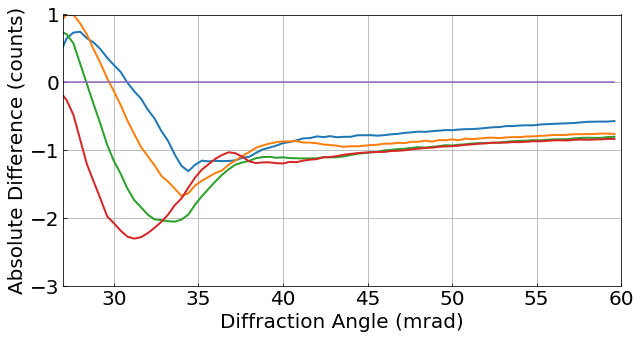

In [115]:
simpath = '/srv/home/chenyu/antisite/PRISMATIC/ConvAngle_noTilt/25.3mrad/25.3mrad/'
exppath = '/srv/home/chenyu/DEbackup/061219/'
fig = plt.figure(figsize=(10,5))
list = [5,3,7,8]
# list=[2,7]
for i in range(len(list)):
    subpath = 'S'+str(list[i])+'/'
    (diff_polar,thickness) = MismatchCalc2(simpath,subpath,exppath)
    diff_lineprofile = np.average(diff_polar,axis=1)
    plt.plot(np.linspace(0,0.4*149,num=150),diff_lineprofile,linewidth = 2,label=str(thickness) + ' uc')
    
plt.plot(np.linspace(0,0.4*149,1000),np.linspace(0,0,1000))
plt.tick_params(labelsize=20,direction='in')
plt.xlabel('Diffraction Angle (mrad)', fontsize=20)
plt.ylabel('Absolute Difference (counts)',fontsize=20)
plt.grid('on')
# plt.legend(fontsize=20)
plt.xlim([27,60])
plt.ylim([-3,1])

S5/ 8
S9/ 9
S8/ 10
S1/ 14
S2/ 16


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


(-3, 1)

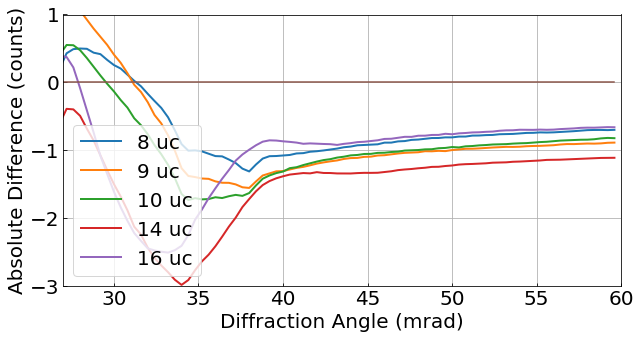

In [117]:
simpath = '/srv/home/chenyu/antisite/PRISMATIC/ConvAngle_noTilt/25.3mrad/25.3mrad/'
exppath = '/srv/home/chenyu/DEbackup/022119/'
fig = plt.figure(figsize=(10,5))
list = [5,9,8,1,2]
for i in range(len(list)):
    subpath = 'S'+str(list[i])+'/'
    (diff_polar,thickness) = MismatchCalc(simpath,subpath,exppath)
    diff_lineprofile = np.average(diff_polar,axis=1)
    plt.plot(np.linspace(0,0.4*149,num=150),diff_lineprofile,linewidth = 2,label=str(thickness) + ' uc')
    
plt.plot(np.linspace(0,0.4*149,1000),np.linspace(0,0,1000))
plt.tick_params(labelsize=20,direction='in')
plt.xlabel('Diffraction Angle (mrad)', fontsize=20)
plt.ylabel('Absolute Difference (counts)',fontsize=20)
plt.grid('on')
plt.legend(fontsize=20)
plt.xlim([27,60])
plt.ylim([-3,1])

In [49]:
def MismatchCalc(simpath,subpath,exppath):
    # Compare simulated PACBED from a unit cell to experiment PACBED
    
    AccumulatedFrame = np.load(exppath + 'AccumulatedFrame.npy')
    BeamLevel = np.load(exppath + 'BeamLevel.npy')
    norm_mask = np.load(exppath + 'norm_mask.npy')
    norm_mask[norm_mask<0.95] = 1

    PACBED_exp = np.load(exppath + subpath + 'PACBED.npy')
    mask = np.heaviside(AccumulatedFrame-50,1)

    thickness = np.load(exppath + subpath + 'SrPeaks_thickness.npy')
    thickness = int(np.mean(thickness)-1)
    print(subpath,thickness)

    PACBED_exp = PACBED_exp*mask/norm_mask + PACBED_exp*(1-mask)
    PACBED_exp = PACBED_exp/BeamLevel
    PACBED_exp = PACBED_exp/150/150

    expMask = np.zeros((69,69))
    expMask[21:43,22:44] = 1
    px_list = np.nonzero(expMask)
    sim_cube = np.load(simpath+'depth0_slice'+str(thickness)+'_110pmss.npy')
    row_list = px_list[0]
    col_list = px_list[1]
    file_list= row_list*69+col_list+1
    PACBED_sim = np.zeros((328,328))

    for ifile in range(file_list.size):
        frame = sim_cube[row_list[ifile],col_list[ifile],:,:]
        PACBED_sim = PACBED_sim + frame

    PACBED_sim = PACBED_sim / file_list.size / 22    
    # resample both simulation and experiment to a new grid, ranges from -40mrad to 40mrad with 1mrad/px

    # dataset for 02/21/19
    center_x = 257
    center_y = 260
    rotation = -27 + 180

    final_size = 200

    exp_pxsize = 0.149
    sim_pxsize = 0.511

    exp_x = np.linspace(-exp_pxsize*center_x, exp_pxsize*(511-center_x), num=512)
    exp_y = np.linspace(-exp_pxsize*center_y, exp_pxsize*(511-center_y), num=512)
    f_exp = scipy.interpolate.RectBivariateSpline(exp_y,exp_x,PACBED_exp)
    final_x = np.linspace(-40,40,num=final_size)
    final_y = np.linspace(-40,40,num=final_size)
    final_xx, final_yy = np.meshgrid(final_x,final_y)
    exp_recon = np.zeros((final_size,final_size))
    exp_recon = f_exp.ev(final_xx,final_yy)
    # exp_recon = exp_recon / exp_pxsize / exp_pxsize * sim_pxsize * sim_pxsize

    sim_x = np.linspace(-sim_pxsize*164, sim_pxsize*(328-164), num=328)
    sim_y = sim_x
    f_sim = scipy.interpolate.RectBivariateSpline(sim_x,sim_y,PACBED_sim)
    sim_recon = np.zeros((final_size,final_size))
    final_x = np.linspace(-40,40,num=final_size)
    final_y = np.linspace(-40,40,num=final_size)
    final_xx, final_yy = np.meshgrid(final_x,final_y)
    final_xx_rotated = final_xx*math.cos(math.radians(rotation))-final_yy*math.sin(math.radians(rotation))
    final_yy_rotated = final_yy*math.cos(math.radians(rotation))+final_xx*math.sin(math.radians(rotation))
    sim_recon = f_sim.ev(final_xx_rotated,final_yy_rotated)
    sim_recon = sim_recon / sim_pxsize / sim_pxsize * exp_pxsize * exp_pxsize
    
    diff_polar = convert((sim_recon-exp_recon)*BeamLevel, [200, 200], center=[100, 100])
    
    return(diff_polar,thickness)

In [46]:
def MismatchCalc2(simpath,subpath,exppath):
    # Compare simulated PACBED from a unit cell to experiment PACBED
    
    AccumulatedFrame = np.load(exppath + 'AccumulatedFrame.npy')
    BeamLevel = np.load(exppath + 'BeamLevel.npy')
    norm_mask = np.load(exppath + 'norm_mask.npy')
    norm_mask[norm_mask<0.95] = 1

    PACBED_exp = np.load(exppath + subpath + 'PACBED.npy')
    mask = np.heaviside(AccumulatedFrame-50,1)

    thickness = np.load(exppath + subpath + 'SrPeaks_thickness.npy')
    thickness = int(np.mean(thickness)-1)
    print(subpath,thickness)

    PACBED_exp = PACBED_exp*mask/norm_mask + PACBED_exp*(1-mask)
    PACBED_exp = PACBED_exp/BeamLevel
    PACBED_exp = PACBED_exp/150/150

    expMask = np.zeros((69,69))
    expMask[21:43,22:44] = 1
    px_list = np.nonzero(expMask)
    sim_cube = np.load(simpath+'depth0_slice'+str(thickness)+'_110pmss.npy')
    row_list = px_list[0]
    col_list = px_list[1]
    file_list= row_list*69+col_list+1
    PACBED_sim = np.zeros((328,328))

    for ifile in range(file_list.size):
        frame = sim_cube[row_list[ifile],col_list[ifile],:,:]
        PACBED_sim = PACBED_sim + frame

    PACBED_sim = PACBED_sim / file_list.size / 22    
    # resample both simulation and experiment to a new grid, ranges from -40mrad to 40mrad with 1mrad/px

    # dataset for 02/21/19
    center_x = 235
    center_y = 259
    rotation = 17 + 90

    final_size = 200

    exp_pxsize = 0.149
    sim_pxsize = 0.511

    exp_x = np.linspace(-exp_pxsize*center_x, exp_pxsize*(511-center_x), num=512)
    exp_y = np.linspace(-exp_pxsize*center_y, exp_pxsize*(511-center_y), num=512)
    f_exp = scipy.interpolate.RectBivariateSpline(exp_y,exp_x,PACBED_exp)
    final_x = np.linspace(-40,40,num=final_size)
    final_y = np.linspace(-40,40,num=final_size)
    final_xx, final_yy = np.meshgrid(final_x,final_y)
    exp_recon = np.zeros((final_size,final_size))
    exp_recon = f_exp.ev(final_xx,final_yy)
    # exp_recon = exp_recon / exp_pxsize / exp_pxsize * sim_pxsize * sim_pxsize

    sim_x = np.linspace(-sim_pxsize*164, sim_pxsize*(328-164), num=328)
    sim_y = sim_x
    f_sim = scipy.interpolate.RectBivariateSpline(sim_x,sim_y,PACBED_sim)
    sim_recon = np.zeros((final_size,final_size))
    final_x = np.linspace(-40,40,num=final_size)
    final_y = np.linspace(-40,40,num=final_size)
    final_xx, final_yy = np.meshgrid(final_x,final_y)
    final_xx_rotated = final_xx*math.cos(math.radians(rotation))-final_yy*math.sin(math.radians(rotation))
    final_yy_rotated = final_yy*math.cos(math.radians(rotation))+final_xx*math.sin(math.radians(rotation))
    sim_recon = f_sim.ev(final_xx_rotated,final_yy_rotated)
    sim_recon = sim_recon / sim_pxsize / sim_pxsize * exp_pxsize * exp_pxsize
    
    diff_polar = convert((sim_recon-exp_recon)*BeamLevel, [200, 200], center=[100, 100])
    

    
    return(diff_polar,thickness)

## Check diffraction for amorphous region

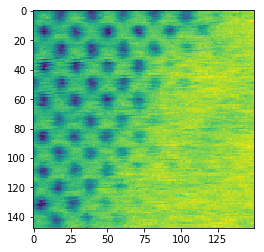

In [96]:
exppath = '/srv/home/chenyu/DEbackup/022119/S10/'
BF = np.load(exppath + 'BF.npy')
PACBED = np.zeros((512,512))
plt.imshow(BF[1:-1,:])
num = 0
for icol in range(125,150):
    for irow in range(150):
        file_num= irow*150+icol+1
        frame = np.load(exppath + 'npy/S10_'+format(int(file_list[ifile]),'05')+'.npy')
        PACBED = PACBED + frame
        num = num + 1
PACBED = PACBED / num

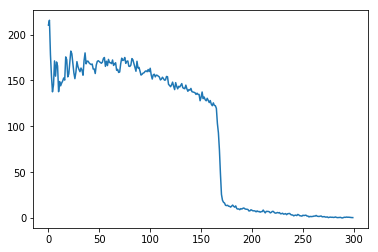

In [110]:
# plt.imshow(PACBED,clim=[0,400])
# plt.colorbar()
kx,ky = PACBED.shape[0:2]
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)
COM_x = np.average(weights_x,weights=PACBED)
COM_y = np.average(weights_y,weights=PACBED)
# plt.scatter(COM_x,COM_y)
PACBED_polar = convert(PACBED,[512,512],center=[COM_y,COM_x])
# plt.imshow(PACBED_polar)
plt.plot(np.average(PACBED_polar,axis=1))

In [112]:
from scipy.interpolate import griddata
from numpy import exp, abs,angle
from scipy.interpolate import RectBivariateSpline

def convert (img, size, center, correction=False, plot=False):
    '''
    :param img: a 2-d array for the image to convert to polar coordinates
    :param center: x,y coordinates for the center of the image
    :param correction: the circular correction
    :param size: [x,y] describing the pixel dimensions of the photo
    :return: polar_img r vs. theta
    '''
    phase_width = 360
    r_inital = 0
    r_final =150
    final_theta, final_r = create_grid(np.linspace(-1*np.pi,np.pi,phase_width),np.arange(0,r_final,1))
#     initial_x, initial_y = create_grid(range(1,size[0]+1),range(1,size[1]+1))
#     initial_y, initial_x = range(1, 513), range(1, 513)
    initial_y, initial_x = range(1, size[0]+1), range(1, size[1]+1)
    final_x, final_y = polar_list_to_cartesian(final_r,final_theta,center)
    
    #initial_theta, initial_r = cartesian_list_to_polar(initial_x,initial_y,center)
#     inten = np.reshape(img,size[0]*size[1])
#     polar_img = griddata((initial_x,initial_y),inten,(final_x,final_y), method='linear')
    inten = img
    spline = RectBivariateSpline(initial_x, initial_y,inten,kx=1,ky=1)
    polar_img = spline.ev(final_x,final_y)
    
    polar_img = np.reshape(polar_img, [r_final, phase_width])
    if plot:
        plt.imshow(polar_img, extent=(0, 6.293, 0, 6))
        plt.show()
    return polar_img

def cartesian_to_polar(x,y,center):
    '''
    A function that converts the x,y coordinates to polar ones.
    -Does not do the circular correction
    '''
    corrected_x= x-center[0]
    corrected_y= y-center[1]
    theta = np.arctan2(corrected_y,corrected_x)
    r = np.sqrt(corrected_x**2+ corrected_y**2)
    return theta,r

def polar_to_cartesian(r, theta, center):
    x = center[0]+r*np.cos(theta)
    y = center[1] +r*np.sin(theta)
    return x,y

def cartesian_list_to_polar(x_list,y_list,center):
    theta_list = []
    r_list = []
    for x,y in zip(x_list,y_list):
        t,r =cartesian_to_polar(x,y,center)
        theta_list.append(t)
        r_list.append(r)
    return theta_list, r_list

def polar_list_to_cartesian(r_list,theta_list, center):
    x_list = []
    y_list = []
    for r, t in zip(r_list,theta_list):
        x,y = polar_to_cartesian(r,t,center)
        x_list.append(x)
        y_list.append(y)
    return x_list,y_list

def create_grid (dimension1,dimension2):
    '''
    Takes data from array of points turns it into a grid of coordinates
    '''
    dim1,dim2 =np.meshgrid(dimension1,dimension2)
    size = len(dimension1)*len(dimension2)
    a,b = np.reshape(dim1,size),np.reshape(dim2,size)
    return a,b

def circular_grid_data(intial_r, initial_theta, intensity, final_r,final_theta):
    #interpolating the radi and theta values from the cartesian points and mapping the intesities to evenly spaced
    # points in r an theta through linear interpolation... possibly some other interpolation....
    #for r,t in zip(final_r,final_theta):

    return


In [8]:
PACBED = np.load('/srv/home/chenyu/DEbackup/022119/S5/PACBED.npy')
PACBED = PACBED * 150 * 150
np.save('/srv/home/chenyu/DEbackup/022119/S5/PACBED.npy',PACBED)